<a href="https://colab.research.google.com/github/alfariziraju/Praktek-Fuzzy-G211220061/blob/main/Praktek_Fuzzy_Tsukamoto_G211220061.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Derajat keanggotaan Suhu (38.0°C):
 Normal = 0.00 (-0.0)
 Tinggi = 0.67 (0.6666666666666666)

Derajat keanggotaan Nadi (110 bpm):
 Normal = 0.00
 Cepat = 0.80

=== Hasil Inferensi Tsukamoto ===
α1 = 0.00, z1 = 50.00
α2 = 0.80, z2 = 90.00
Output (z*) = 90.00


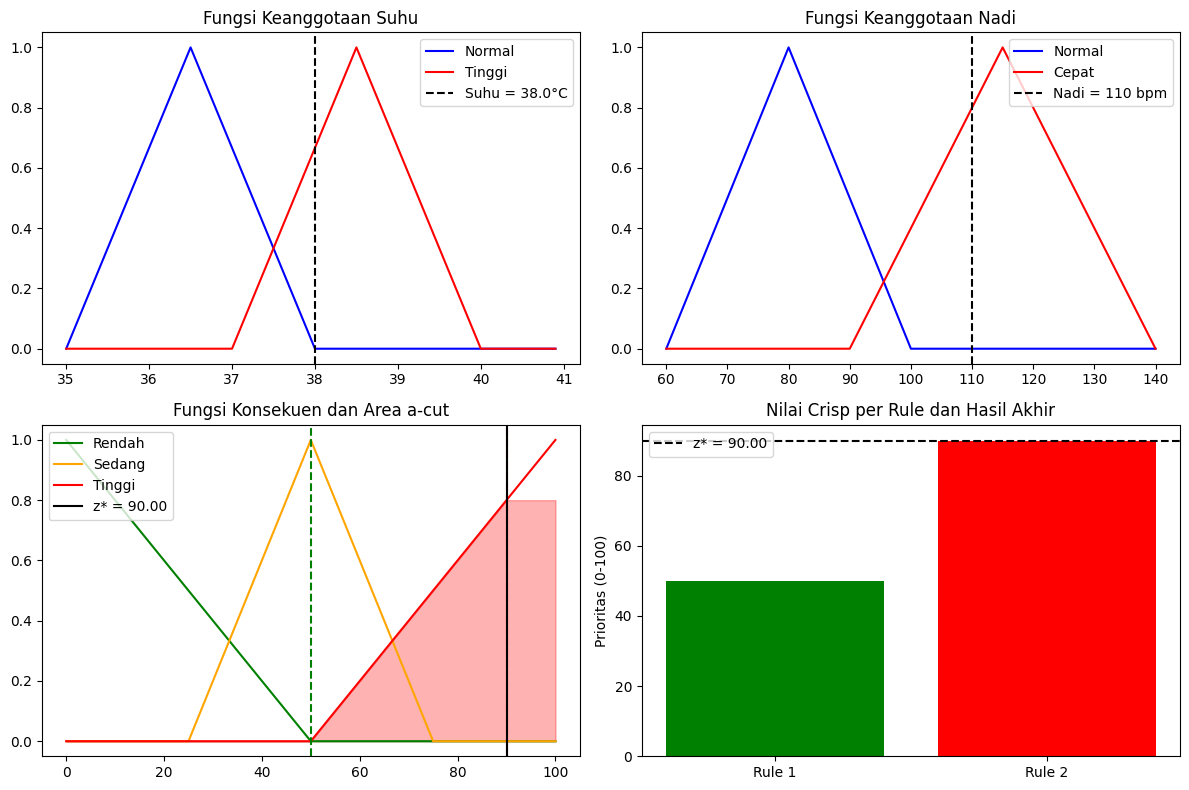

In [ ]:
# Install scikit-fuzzy if not already installed
!pip install scikit-fuzzy

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# --- 1. Domain variabel dan Fungsi Keanggotaan ---

# 1.1 Domain (Universe of Discourse)
x_temp = np.arange(35, 41, 0.1)     # Suhu (°C)
x_pulse = np.arange(60, 141, 1)    # Denyut Nadi (bpm)
x_priority = np.arange(0, 101, 1) # Prioritas (0-100)

# 1.2 Fungsi Keanggotaan Suhu (trimf/segitiga)
# Normal (35-38, turun) -> menggunakan [35, 36.5, 38]
temp_normal = fuzz.trimf(x_temp, [35, 36.5, 38])
# Tinggi (37-40, naik) -> menggunakan [37, 38.5, 40]
temp_high = fuzz.trimf(x_temp, [37, 38.5, 40])

# 1.3 Fungsi Keanggotaan Denyut Nadi (trimf/segitiga)
# Normal (60-100, turun) -> menggunakan [60, 80, 100]
pulse_normal = fuzz.trimf(x_pulse, [60, 80, 100])
# Cepat (80-140, naik) -> menggunakan [90, 115, 140]
pulse_fast = fuzz.trimf(x_pulse, [90, 115, 140])

# 1.4 Fungsi Keanggotaan Output Prioritas (Monoton)
# Dalam Tsukamoto, konsekuen harus monoton
# Rendah (0-50, monoton turun) -> Linear dari (0, 1) ke (50, 0)
priority_low = fuzz.trapmf(x_priority, [0, 0, 50, 50])
# *Catatan: Materi menggunakan trimf untuk output, tetapi diinterpretasikan secara monoton.
# Untuk simulasi Tsukamoto dengan fungsi monoton linear:
# priority_low: nilai 1 di 0, nilai 0 di 50.
# priority_high: nilai 0 di 50, nilai 1 di 100.
# Karena skfuzzy tidak memiliki fungsi monoton langsung, kita akan menghitung nilai z secara manual
# berdasarkan invers fungsi keanggotaan monoton.

# --- 2. Input Pasien dan Fuzzifikasi ---

temp_in = 38.0  # Suhu pasien (38.0 °C)
pulse_in = 110  # Denyut nadi pasien (110 bpm)

# Fuzzifikasi
μ_temp_normal = fuzz.interp_membership(x_temp, temp_normal, temp_in)
μ_temp_high = fuzz.interp_membership(x_temp, temp_high, temp_in)
μ_pulse_normal = fuzz.interp_membership(x_pulse, pulse_normal, pulse_in)
μ_pulse_fast = fuzz.interp_membership(x_pulse, pulse_fast, pulse_in)

print(f"Derajat keanggotaan Suhu ({temp_in:.1f}°C):")
print(f" Normal = {μ_temp_normal:.2f} ({(38.0 - 38) / (36.5 - 38.0)})")
print(f" Tinggi = {μ_temp_high:.2f} ({(38.0 - 37) / (38.5 - 37)})")
print("\nDerajat keanggotaan Nadi (110 bpm):")
print(f" Normal = {μ_pulse_normal:.2f}")
print(f" Cepat = {μ_pulse_fast:.2f}")

# --- 3. Inferensi (Rule Evaluation) ---

# Rule 1: Jika Suhu Normal DAN Nadi Normal -> Prioritas Rendah
alpha1 = min(μ_temp_normal, μ_pulse_normal)

# Rule 2: Jika Suhu Tinggi ATAU Nadi Cepat -> Prioritas Tinggi
alpha2 = max(μ_temp_high, μ_pulse_fast)

# --- 4. Defuzzifikasi (Metode Tsukamoto) ---

# Mencari nilai z_i (nilai crisp prioritas) dari setiap alpha_i menggunakan fungsi invers.

# 4.1 Invers Fungsi Monoton Prioritas Rendah (Range 0-50, turun)
# Fungsi keanggotaan (μ) linear turun: μ = 1 - (z/50)
# Fungsi Invers (z): z1 = 50 * (1 - μ)
z1 = 50 * (1 - alpha1)

# 4.2 Invers Fungsi Monoton Prioritas Tinggi (Range 50-100, naik)
# Fungsi keanggotaan (μ) linear naik: μ = (z - 50) / 50
# Fungsi Invers (z): z2 = 50 + 50 * μ
z2 = 50 + 50 * alpha2

# 4.3 Defuzzifikasi Akhir (Rata-rata Terbobot / Weighted Average)
# z* = (Σ(alpha_i * z_i)) / (Σ alpha_i)
z = (alpha1 * z1 + alpha2 * z2) / (alpha1 + alpha2)

print("\n=== Hasil Inferensi Tsukamoto ===")
print(f"α1 = {alpha1:.2f}, z1 = {z1:.2f}")
print(f"α2 = {alpha2:.2f}, z2 = {z2:.2f}")
print(f"Output (z*) = {z:.2f}")

# --- 5. Visualisasi ---

# Fungsi keanggotaan output yang 'ideal' untuk plot
# Walaupun Tsukamoto hanya menggunakan nilai z_i, plot ini membantu visualisasi fungsi output.
priority_low_plot = fuzz.trimf(x_priority, [0, 0, 50])
priority_med_plot = fuzz.trimf(x_priority, [25, 50, 75])
priority_high_plot = fuzz.trimf(x_priority, [50, 100, 100])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

## Plot 1: Suhu
axs[0,0].plot(x_temp, temp_normal, 'b', label='Normal')
axs[0,0].plot(x_temp, temp_high, 'r', label='Tinggi')
axs[0,0].axvline(temp_in, color='k', linestyle='--', label=f'Suhu = {temp_in:.1f}°C')
axs[0,0].set_title('Fungsi Keanggotaan Suhu')
axs[0,0].legend()

## Plot 2: Nadi
axs[0,1].plot(x_pulse, pulse_normal, 'b', label='Normal')
axs[0,1].plot(x_pulse, pulse_fast, 'r', label='Cepat')
axs[0,1].axvline(pulse_in, color='k', linestyle='--', label=f'Nadi = {pulse_in:.0f} bpm')
axs[0,1].set_title('Fungsi Keanggotaan Nadi')
axs[0,1].legend()

## Plot 3: Fungsi Konsekuen (Prioritas) dan a-cut
axs[1,0].plot(x_priority, priority_low_plot, 'g', label='Rendah')
axs[1,0].plot(x_priority, priority_med_plot, 'orange', label='Sedang')
axs[1,0].plot(x_priority, priority_high_plot, 'r', label='Tinggi')

# Area a-cut (hanya untuk visualisasi batas alpha)
axs[1,0].fill_between(x_priority, 0, np.fmin(alpha1, priority_low_plot), color='g', alpha=0.3)
axs[1,0].fill_between(x_priority, 0, np.fmin(alpha2, priority_high_plot), color='r', alpha=0.3)

# Nilai z_i dan hasil akhir z*
axs[1,0].axvline(z1, color='g', linestyle='--')
axs[1,0].axvline(z2, color='r', linestyle='--')
axs[1,0].axvline(z, color='k', linestyle='-', label=f'z* = {z:.2f}')
axs[1,0].set_title('Fungsi Konsekuen dan Area a-cut')
axs[1,0].legend(loc='upper left')

## Plot 4: Nilai Crisp per Rule
axs[1,1].bar(['Rule 1', 'Rule 2'], [z1, z2], color=['g','r'])
axs[1,1].axhline(z, color='k', linestyle='--', label=f'z* = {z:.2f}')
axs[1,1].set_ylabel('Prioritas (0-100)')
axs[1,1].set_title('Nilai Crisp per Rule dan Hasil Akhir')
axs[1,1].legend()

plt.tight_layout()
plt.show()